<a href="https://colab.research.google.com/github/Karnikasri/Toxic_comment_classifier/blob/main/Toxic_comment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

#data visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

#to avoid warnings
import warnings
warnings.filterwarnings('ignore')


In [2]:
!pip install torch

In [3]:
!pip install transformers


In [4]:
df = pd.read_csv('/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/train.csv.zip')
df.head(10)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


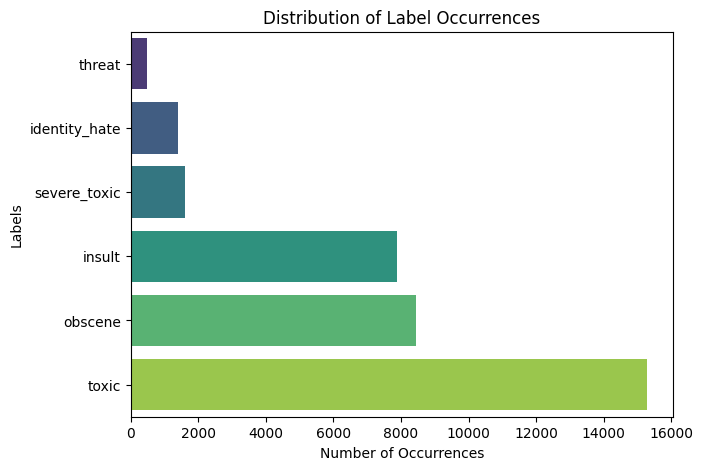

In [5]:
# Visualizing the class distribution of the 'label' column
column_labels = df.columns.tolist()[2:]
label_counts = df[column_labels].sum().sort_values()


# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Create a horizontal bar plot using Seaborn
ax = sns.barplot(x=label_counts.values,
				y=label_counts.index, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')

# Show the plot
plt.show()


In [6]:
df[column_labels].sum().sort_values()


,0
threat,478
identity_hate,1405
severe_toxic,1595
insult,7877
obscene,8449
toxic,15294


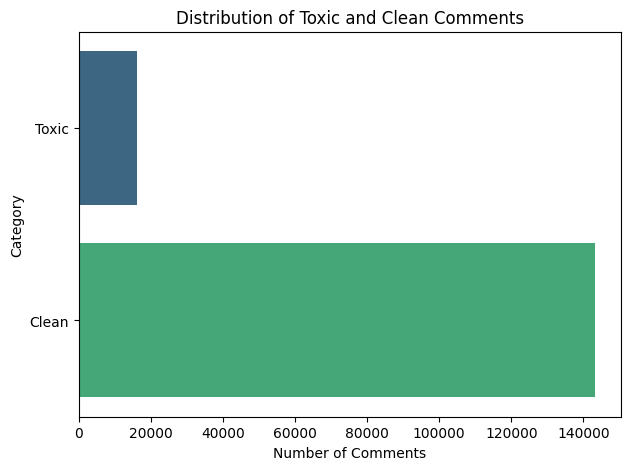

In [7]:
# Create subsets based on toxic and clean comments
train_toxic = df[df[column_labels].sum(axis=1) > 0]
train_clean = df[df[column_labels].sum(axis=1) == 0]

# Number of toxic and clean comments
num_toxic = len(train_toxic)
num_clean = len(train_clean)

# Create a DataFrame for visualization
plot_data = pd.DataFrame(
	{'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

# Create a black background for the plot
plt.figure(figsize=(7, 5))

# Horizontal bar plot
ax = sns.barplot(x='Count', y='Category', data=plot_data, palette='viridis')


# Add labels and title to the plot
plt.xlabel('Number of Comments')
plt.ylabel('Category')
plt.title('Distribution of Toxic and Clean Comments')

# Set ticks' color to white
ax.tick_params()

# Show the plot
plt.show()


In [8]:
print(train_toxic.shape)
print(train_clean.shape)


(16225, 8)
(143346, 8)


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS


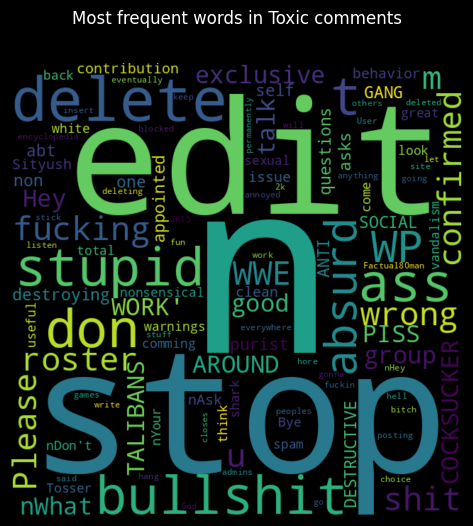

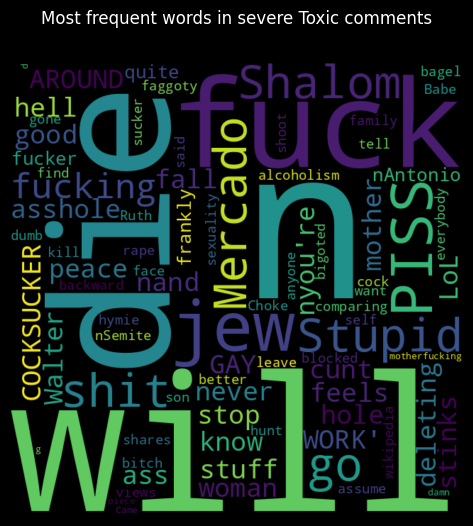

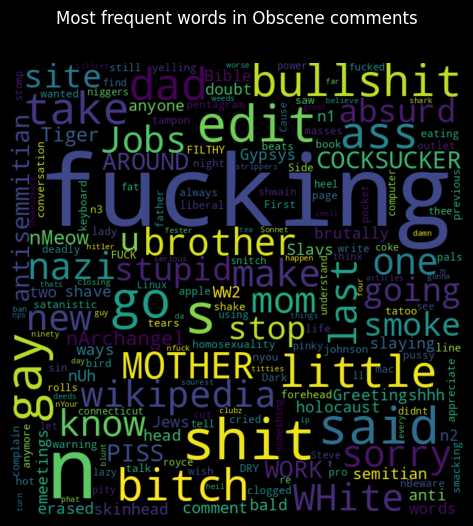

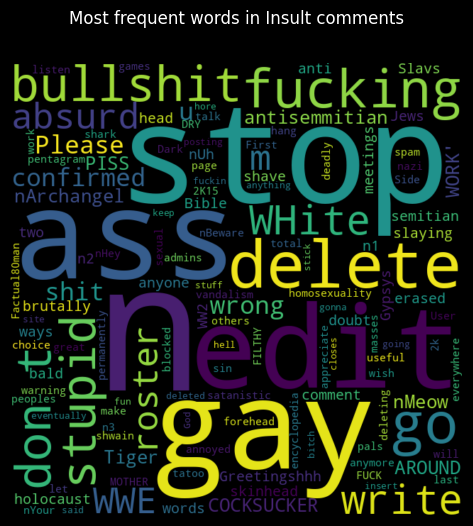

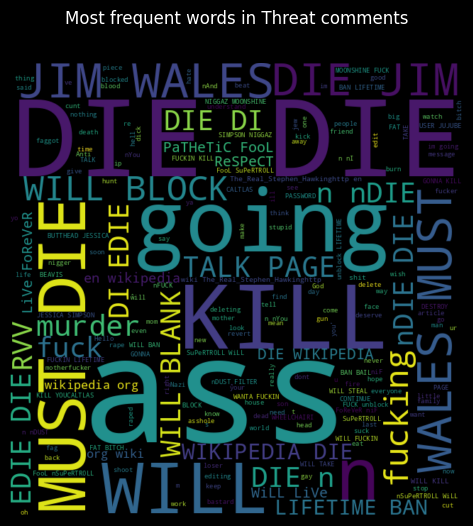

In [10]:
#plot the most frequent words in the dataset using word cloud
#font size is chosen by the frequency of the word in the data
def word_plot(column,text):

    comments = df['comment_text'].loc[column == 1].values     # sort by toxicity

    word_cloud = WordCloud( width = 640, height = 640, background_color = 'black',
                stopwords = STOPWORDS).generate(str(comments))     # stopwords are a,an,the

    fig = plt.figure( figsize = (8, 5), facecolor = 'k', edgecolor = 'k')
    plt.subplot()
    plt.imshow(word_cloud, interpolation = 'bilinear')
    plt.suptitle("Most frequent words in " +  text , y = 1.06,color = "white")
    plt.tight_layout(pad = 0)
    plt.axis('off')
    plt.show()

word_plot(df['toxic'], "Toxic comments")
word_plot(df['severe_toxic'],"severe Toxic comments")
word_plot(df['obscene'],"Obscene comments")
word_plot(df['insult'],"Insult comments")
word_plot(df['threat'],"Threat comments")

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Split data into training, testing sets & validation sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
	df['comment_text'], df.iloc[:, 2:], test_size=0.25, random_state=42)
# validation set
test_texts, val_texts, test_labels, val_labels = train_test_split(
	test_texts, test_labels, test_size=0.5, random_state=42)

# Create a CountVectorizer to convert text data into numerical features
vectorizer = CountVectorizer()

# Fit the vectorizer to the training data and transform it
X_train = vectorizer.fit_transform(train_texts)

# Transform the test data using the fitted vectorizer
X_test = vectorizer.transform(test_texts)


# Create a dictionary to store trained models for each label
models = {}

# Train separate models for each label and store predictions in a list
test_predictions_list = []
for label in train_labels.columns:
    model = LogisticRegression()
    # Now you can use X_train here
    model.fit(X_train, train_labels[label])
    models[label] = model

    # Make predictions for the current label
    test_predictions_list.append(model.predict(X_test))

# Combine predictions into a DataFrame with the same shape as test_labels
test_predictions = pd.DataFrame(test_predictions_list).T
test_predictions.columns = train_labels.columns

# Evaluate
#Since it is a multi-label classification calculating accuracy & classfication_report for each label
for label in train_labels.columns:
    print(f"Metrics for {label}:")
    print("Test Accuracy:", accuracy_score(test_labels[label], test_predictions[label]))
    print(classification_report(test_labels[label], test_predictions[label]))
    print("\n")

Metrics for toxic:
Test Accuracy: 0.9586383234733781
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18041
           1       0.85      0.69      0.76      1905

    accuracy                           0.96     19946
   macro avg       0.91      0.84      0.87     19946
weighted avg       0.96      0.96      0.96     19946



Metrics for severe_toxic:
Test Accuracy: 0.9900731976336108
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     19747
           1       0.51      0.19      0.28       199

    accuracy                           0.99     19946
   macro avg       0.75      0.59      0.64     19946
weighted avg       0.99      0.99      0.99     19946



Metrics for obscene:
Test Accuracy: 0.9765366489521708
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     18868
           1       0.86      0.67      0.76      1078

    accura

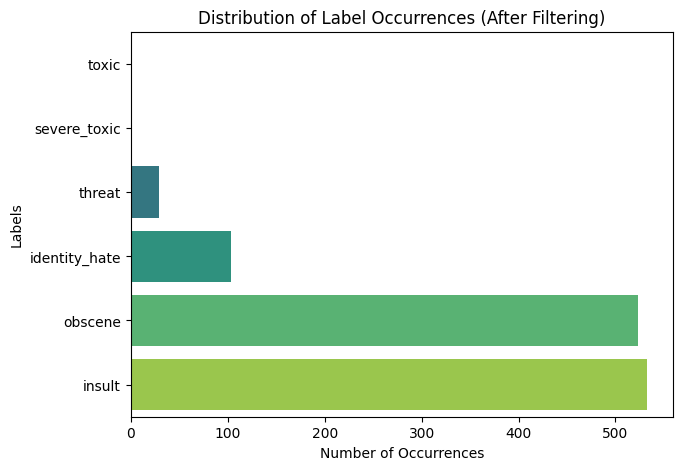

In [19]:
# prompt: generate code for removing toxic and severe toxic from the above part and compare result

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
import warnings
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

#data visualisation libraries


#to avoid warnings
warnings.filterwarnings('ignore')

# Assuming necessary installations are already done in previous code execution
# !pip install torch
# !pip install transformers

df = pd.read_csv('/content/drive/MyDrive/jigsaw-toxic-comment-classification-challenge/train.csv.zip')

# Remove rows where 'toxic' or 'severe_toxic' is 1
df_filtered = df[(df['toxic'] == 0) & (df['severe_toxic'] == 0)]

# Re-run the analysis with the filtered data
column_labels = df_filtered.columns.tolist()[2:]
label_counts = df_filtered[column_labels].sum().sort_values()

# ... (rest of your code using df_filtered instead of df)

# Example: Visualizing the class distribution of the 'label' column after filtering
plt.figure(figsize=(7, 5))
ax = sns.barplot(x=label_counts.values, y=label_counts.index, palette='viridis')
plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences (After Filtering)')
plt.show()

# ... (rest of your code, modifying usages of df to df_filtered where appropriate)
# Specifically, change df to df_filtered in the following sections:
# - Create subsets based on toxic and clean comments
# - plot the most frequent words in the dataset using word cloud
# - Split data into training, testing sets & validation sets


# Split data into training, testing sets & validation sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_filtered['comment_text'], df_filtered.iloc[:, 2:], test_size=0.25, random_state=42)
# validation set
test_texts, val_texts, test_labels, val_labels = train_test_split(
    test_texts, test_labels, test_size=0.5, random_state=42)

# ... (rest of your code)